<img src="https://www.iscte-iul.pt/assets/images/logo_iscte_detailed.svg" style="width: 450px;margin-top:30px;" align ="center">

<div style= "font-size: 35px;  margin-top:40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>User Clustering: <strong>E-Commerce</strong></center></div>
<div style= "font-size: 30px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Organizing all variables and data to the models phase</center></div>

<div style= "font-size: 27px;font-weight:bold;line-height: 1.1; margin-top:40px; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Processamento e Modelação de Big Data 2024/2025</center></div> <br>

   <div style= "font-size: 20px;font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center> Grupo 7:</center></div>
   <div><center> Diogo Freitas | 104841 </center></div>
   <div><center> João Francisco Botas | 104782 </center></div>
   <div><center> Miguel Gonçalves | 105944 </center></div>
   <div><center> Ricardo Galvão | 105285 </center></div>

In [1]:
# Importações Básicas
import pyspark
import pandas as pd
from pyspark.sql import SparkSession, Row
import pyspark.sql.functions as F
from pyspark.sql.functions import split, isnan, col, isnull, avg, count, round
from pyspark.sql.types import (
    StructType, StructField,
    StringType, LongType, DoubleType, TimestampType
)


# Create a Spark session
spark = SparkSession.builder \
    .appName("Projeto") \
    .getOrCreate()

In [2]:
# Criação da Sessão
spark = SparkSession.builder.appName("Projeto").getOrCreate()

# Leitura de dados
data_dir = '../data/'
file_ec = data_dir + 'user_df.parquet'

# Carrega as primeiras 10.000 linhas
ec_user = spark.read.parquet(file_ec)

In [3]:
ec_user.show()

+---------+-------------+-----------+-----------+----------+---------+---------+-------+------------+----+----+-----+-----------+
|  user_id|average_price|total_views|electronics|appliances|furniture|computers|apparel|construction|auto|kids|sport|accessories|
+---------+-------------+-----------+-----------+----------+---------+---------+-------+------------+----+----+-----+-----------+
|515761354|       141.55|          3|          0|         3|        0|        0|      0|           0|   0|   0|    0|          0|
|565865924|       949.47|          1|          1|         0|        0|        0|      0|           0|   0|   0|    0|          0|
|527322328|      197.797|          7|          0|         7|        0|        0|      0|           0|   0|   0|    0|          0|
|553334193|       172.23|          1|          1|         0|        0|        0|      0|           0|   0|   0|    0|          0|
|565921426|       165.26|          1|          1|         0|        0|        0|      0|  

## KMeans Clustering

In [4]:
feature_cols = ec_user.columns
feature_cols.pop(0)

'user_id'

In [14]:
from pyspark.ml.feature import VectorAssembler, MaxAbsScaler


In [20]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_prescale")
client_features = assembler.transform(ec_user)

scaler = MaxAbsScaler(inputCol="features_prescale", outputCol="features")
client_features = scaler.fit(client_features).transform(client_features)

In [21]:
client_features.show()

+---------+-------------+-----------+-----------+----------+---------+---------+-------+------------+----+----+-----+-----------+--------------------+--------------------+
|  user_id|average_price|total_views|electronics|appliances|furniture|computers|apparel|construction|auto|kids|sport|accessories|   features_prescale|            features|
+---------+-------------+-----------+-----------+----------+---------+---------+-------+------------+----+----+-----+-----------+--------------------+--------------------+
|515761354|       141.55|          3|          0|         3|        0|        0|      0|           0|   0|   0|    0|          0|(12,[0,1,3],[141....|(12,[0,1,3],[0.06...|
|565865924|       949.47|          1|          1|         0|        0|        0|      0|           0|   0|   0|    0|          0|(12,[0,1,2],[949....|(12,[0,1,2],[0.42...|
|527322328|      197.797|          7|          0|         7|        0|        0|      0|           0|   0|   0|    0|          0|(12,[0,1,3]

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [28]:
silhouette_score=[] 
  
evaluator = ClusteringEvaluator(predictionCol='prediction', 
                                featuresCol='features',  
                                metricName='silhouette',  
                                distanceMeasure='squaredEuclidean') 
  
for i in range(2,15): 
    kmeans=KMeans(featuresCol='features', k=i) 
    model=kmeans.fit(client_features) 
    predictions=model.transform(client_features) 
    score=evaluator.evaluate(predictions) 
    silhouette_score.append(score) 
    print('Silhouette Score for k =',i,'is',score)

Silhouette Score for k = 2 is 0.6332562251720768
Silhouette Score for k = 3 is 0.6385460218100838
Silhouette Score for k = 4 is 0.6661240169681092
Silhouette Score for k = 5 is 0.4989139228311749
Silhouette Score for k = 6 is 0.49845982939889893
Silhouette Score for k = 7 is 0.3762151661811034
Silhouette Score for k = 8 is 0.5072148698980378
Silhouette Score for k = 9 is 0.2426372847290946
Silhouette Score for k = 10 is 0.5713529135038731
Silhouette Score for k = 11 is 0.2711111665882319
Silhouette Score for k = 12 is 0.31478953458025954
Silhouette Score for k = 13 is 0.47607736342373896
Silhouette Score for k = 14 is 0.32564643551277833


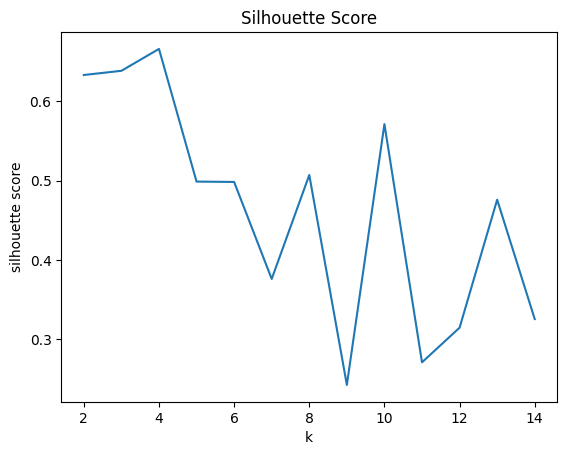

In [30]:
import matplotlib.pyplot as plt 
  
plt.plot(range(2,15),silhouette_score) 
plt.xlabel('k') 
plt.ylabel('silhouette score') 
plt.title('Silhouette Score') 
plt.show()

In [32]:
optimal_k = silhouette_score.index(max(silhouette_score)) + 2

In [33]:
# Trains a k-means model.
kmeans = KMeans().setK(optimal_k).setSeed(1)
model = kmeans.fit(client_features)

# Make predictions
predictions = model.transform(client_features)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.6582967522717171
Cluster Centers: 
[0.10226844 0.05181945 0.0259042  0.01007292 0.01003992 0.01148583
 0.00470951 0.01164875 0.00842294 0.0046147  0.00197133 0.00086406]
[4.83489510e-01 6.04031527e-02 5.13468013e-02 1.70285228e-03
 4.11522634e-03 4.15263749e-02 9.57029381e-05 2.93944738e-04
 0.00000000e+00 0.00000000e+00 6.85871056e-03 0.00000000e+00]
[0.14771291 0.29300397 0.26547389 0.05044021 0.0270793  0.01353965
 0.00470064 0.0106383  0.00283688 0.01170213 0.01205674 0.01367781]
[0.03565212 0.3747646  0.00505051 0.         0.         0.
 0.50904393 0.         0.         0.         0.         0.        ]


In [34]:
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  243|
|         3|    9|
|         2|   94|
|         0| 1116|
+----------+-----+



In [35]:
cluster_profiles = predictions.groupBy("prediction").mean()

In [36]:
for c in cluster_profiles.columns:
    cluster_profiles = cluster_profiles.withColumn(c, F.round(c, 2))

In [37]:
cluster_profiles.show()

+----------+--------------+------------------+----------------+----------------+---------------+--------------+--------------+------------+-----------------+---------+---------+----------+----------------+---------------+
|prediction|  avg(user_id)|avg(average_price)|avg(total_views)|avg(electronics)|avg(appliances)|avg(furniture)|avg(computers)|avg(apparel)|avg(construction)|avg(auto)|avg(kids)|avg(sport)|avg(accessories)|avg(prediction)|
+----------+--------------+------------------+----------------+----------------+---------------+--------------+--------------+------------+-----------------+---------+---------+----------+----------------+---------------+
|         1|5.3792486298E8|           1082.75|            3.56|            2.26|            0.1|          0.18|          0.91|         0.0|              0.0|      0.0|      0.0|       0.1|             0.0|            1.0|
|         3|  5.39811226E8|             79.84|           22.11|            0.22|            0.0|           0.0| 